In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

In [12]:
model_name = "DeepChem/ChemBERTa-77M-MTR"
tokenizer = AutoTokenizer.from_pretrained(model_name)
chemberta_model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
chemberta_model.to(device)
chemberta_model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(600, 384, padding_idx=1)
    (position_embeddings): Embedding(515, 384, padding_idx=1)
    (token_type_embeddings): Embedding(1, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.144, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-2): 3 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.109, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dr

In [13]:
def featurize_smiles(smiles_list):
    features = []
    with torch.no_grad():
        for smiles in smiles_list:
            encoded = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True).to(device)
            output = chemberta_model(**encoded)
            features.append(output.pooler_output.squeeze(0))

    features_tensor = torch.stack(features)
    return features_tensor.to(dtype=torch.float32)

In [14]:
df = pd.read_csv("/kaggle/input/qm9-smiles-props/qm9_smiles_properties.csv")  
smiles = df["SMILES"].values
target = df["G"].values 

features = featurize_smiles(smiles)

In [15]:
def prepare_data(features, target, train_size=0.75):
    X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=(1 - train_size), random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [16]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim):
        super(PredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [17]:
def train_model(features, target, epochs, train_size, batch_size=32, lr=0.001):
    print(f"\nTraining with {int(train_size * 100)}% of the data:")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(features, target, train_size)
    
    train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
    val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
    test_tensor = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))
    
    train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)
    
    input_dim = features.shape[1]
    model = PredictionModel(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    consecutive_increase_counter = 0
    max_allowed_increases = 4
    prev_val_loss = float('inf')
    
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        if avg_val_loss > prev_val_loss:
            consecutive_increase_counter += 1
        else:
            consecutive_increase_counter = 0 
        
        if consecutive_increase_counter >= max_allowed_increases:
            print("Early stopping triggered!")
            break
        
        prev_val_loss = avg_val_loss

    plt.plot(train_losses[1:], label='Train Loss')
    plt.plot(val_losses[1:], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model, test_loader, device

In [18]:
def evaluate_model(model, test_loader, device):
    model.eval()
    actual_values, predicted_values = [], []

    start_time = time.time()
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze()
            actual_values.extend(batch_y.cpu().numpy())
            predicted_values.extend(outputs.cpu().numpy())
    end_time = time.time()
    
    actual_values, predicted_values = np.array(actual_values), np.array(predicted_values)
    
    mse = mean_squared_error(actual_values, predicted_values)
    mae = mean_absolute_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)
    inference_time = (end_time - start_time) / len(test_loader)

    print(f"Inference Time per 1000 samples: {inference_time*1000:.4f} seconds")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-Squared (R²): {r2:.4f}")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.6, label="Predictions")
    plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color="red", linestyle="--", label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    plt.legend()
    plt.grid()
    plt.show()


Training with 75% of the data:


/tmp/ipykernel_31/3804434592.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
/tmp/ipykernel_31/3804434592.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_tensor = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
/tmp/ipykernel_31/3804434592.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = TensorDataset(t

Epoch [1/100], Train Loss: 5751.2638, Validation Loss: 270.1701
Epoch [2/100], Train Loss: 217.4470, Validation Loss: 174.0171
Epoch [3/100], Train Loss: 158.6105, Validation Loss: 142.3173
Epoch [4/100], Train Loss: 129.6282, Validation Loss: 115.9309
Epoch [5/100], Train Loss: 111.6928, Validation Loss: 108.0852
Epoch [6/100], Train Loss: 99.6747, Validation Loss: 93.3862
Epoch [7/100], Train Loss: 91.0559, Validation Loss: 84.8455
Epoch [8/100], Train Loss: 84.3881, Validation Loss: 78.3737
Epoch [9/100], Train Loss: 79.1146, Validation Loss: 77.7039
Epoch [10/100], Train Loss: 74.8570, Validation Loss: 71.2635
Epoch [11/100], Train Loss: 70.3924, Validation Loss: 67.7260
Epoch [12/100], Train Loss: 66.9475, Validation Loss: 64.0210
Epoch [13/100], Train Loss: 64.5001, Validation Loss: 61.8394
Epoch [14/100], Train Loss: 61.5072, Validation Loss: 56.5458
Epoch [15/100], Train Loss: 59.7978, Validation Loss: 60.5789
Epoch [16/100], Train Loss: 58.2648, Validation Loss: 54.9970
Epoch 

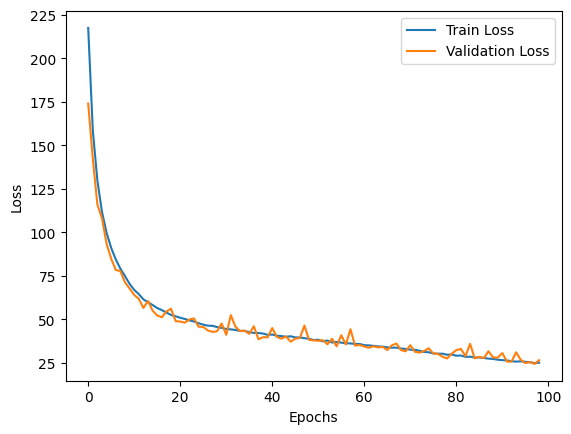

Inference Time per 1000 samples: 0.6202 seconds
Mean Squared Error (MSE): 25.5071
Mean Absolute Error (MAE): 3.5190
R-Squared (R²): 0.9840


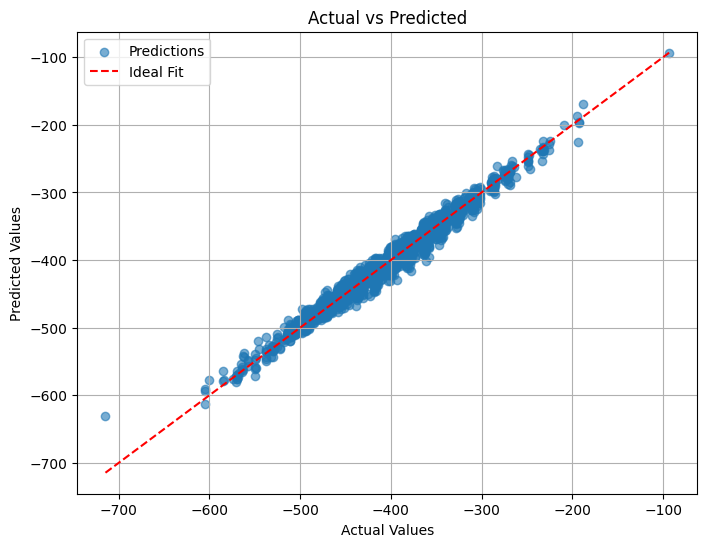

In [20]:
trained_model, test_loader, device = train_model(features, target, epochs=100, train_size=0.75)
evaluate_model(trained_model, test_loader, device)

# **Property Conditioned VAE**

In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [22]:
df = pd.read_csv('/kaggle/input/qm9-smiles-props/qm9_smiles_properties.csv')
df = df[['SMILES', 'G']].dropna()

In [35]:
MAX_LEN = max(len(s) + 2 for s in df['SMILES']) 
BATCH_SIZE = 64
LATENT_DIM = 64
PROPERTY_DIM = 1
HIDDEN_DIM = 256
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
tokens = set()
for s in df['SMILES']:
    tokens.update(list(s))
tokens = sorted(tokens)
tokens = ['<pad>', '<bos>', '<eos>', '<unk>'] + tokens
tok2idx = {ch: i for i, ch in enumerate(tokens)}
idx2tok = {i: ch for ch, i in tok2idx.items()}

def tokenize(smiles):
    tokens = ['<bos>'] + list(smiles) + ['<eos>']
    ids = [tok2idx.get(t, tok2idx['<unk>']) for t in tokens]
    return ids[:MAX_LEN] + [tok2idx['<pad>']] * (MAX_LEN - len(ids))

In [37]:
class SmilesDataset(Dataset):
    def __init__(self, smiles, properties):
        self.smiles = smiles
        self.props = properties

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        x = torch.tensor(tokenize(self.smiles[idx]), dtype=torch.long)
        y = torch.tensor(self.props[idx], dtype=torch.float32)
        return x, y

In [38]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(tok2idx), HIDDEN_DIM)
        self.rnn = nn.GRU(HIDDEN_DIM, HIDDEN_DIM, batch_first=True)
        self.fc_mu = nn.Linear(HIDDEN_DIM, LATENT_DIM)
        self.fc_logvar = nn.Linear(HIDDEN_DIM, LATENT_DIM)

    def forward(self, x):
        x = self.embed(x)
        _, h = self.rnn(x)
        h = h.squeeze(0)
        return self.fc_mu(h), self.fc_logvar(h)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(tok2idx), HIDDEN_DIM)
        self.rnn = nn.GRU(HIDDEN_DIM + LATENT_DIM + PROPERTY_DIM, HIDDEN_DIM, batch_first=True)
        self.fc_out = nn.Linear(HIDDEN_DIM, len(tok2idx))

    def forward(self, x, z, prop):
        x = self.embed(x)
        seq_len = x.size(1)
        z = z.unsqueeze(1).expand(-1, seq_len, -1)
        prop = prop.unsqueeze(1).expand(-1, seq_len, -1)
        x = torch.cat([x, z, prop], dim=-1)
        out, _ = self.rnn(x)
        return self.fc_out(out)


class PropertyVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x, prop):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        logits = self.decoder(x, z, prop.unsqueeze(-1))
        return logits, mu, logvar

In [39]:
train_smi, test_smi, train_g, test_g = train_test_split(df['SMILES'], df['G'], test_size=0.1, random_state=42)
train_ds = SmilesDataset(train_smi.tolist(), train_g.tolist())
test_ds = SmilesDataset(test_smi.tolist(), test_g.tolist())
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

model = PropertyVAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=tok2idx['<pad>'])

In [40]:
EPOCHS = 100

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = epoch_recon = epoch_kl = 0
    for x, prop in train_dl:
        x, prop = x.to(DEVICE), prop.to(DEVICE)
        optimizer.zero_grad()
        logits, mu, logvar = model(x[:, :-1], prop)  # logits: [B, MAX_LEN, V]
        target = x[:, 1:]
        logits = logits[:, :target.size(1), :]  # ensure same length
        recon_loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()
    train_losses.append(epoch_loss / len(train_dl))

    model.eval()
    with torch.no_grad():
        val_loss = val_recon = val_kl = 0
        for x, prop in test_dl:
            x, prop = x.to(DEVICE), prop.to(DEVICE)
            logits, mu, logvar = model(x[:, :-1], prop)
            target = x[:, 1:]
            logits = logits[:, :target.size(1), :]
            recon_loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
            loss = recon_loss + kl_loss
            val_loss += loss.item()
        test_losses.append(val_loss / len(test_dl))

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch [1/100], Train Loss: 1.0598, Test Loss: 0.8826
Epoch [2/100], Train Loss: 0.8540, Test Loss: 0.8533
Epoch [3/100], Train Loss: 0.8167, Test Loss: 0.8032
Epoch [4/100], Train Loss: 0.7939, Test Loss: 0.7916
Epoch [5/100], Train Loss: 0.7844, Test Loss: 0.7756
Epoch [6/100], Train Loss: 0.7722, Test Loss: 0.7682
Epoch [7/100], Train Loss: 0.7654, Test Loss: 0.7654
Epoch [8/100], Train Loss: 0.7599, Test Loss: 0.7574
Epoch [9/100], Train Loss: 0.7580, Test Loss: 0.7508
Epoch [10/100], Train Loss: 0.7521, Test Loss: 0.7491
Epoch [11/100], Train Loss: 0.7495, Test Loss: 0.7467
Epoch [12/100], Train Loss: 0.7467, Test Loss: 0.7409
Epoch [13/100], Train Loss: 0.7447, Test Loss: 0.7413
Epoch [14/100], Train Loss: 0.7427, Test Loss: 0.7477
Epoch [15/100], Train Loss: 0.7397, Test Loss: 0.7482
Epoch [16/100], Train Loss: 0.7381, Test Loss: 0.7420
Epoch [17/100], Train Loss: 0.7363, Test Loss: 0.7432
Epoch [18/100], Train Loss: 0.7355, Test Loss: 0.7353
Epoch [19/100], Train Loss: 0.7331, T

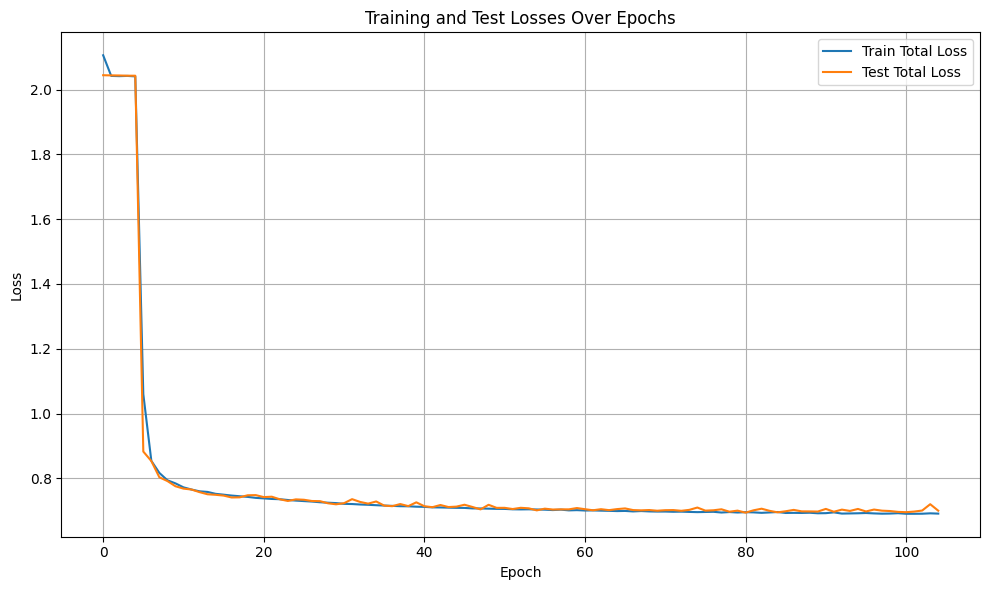

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Total Loss')
plt.plot(test_losses, label='Test Total Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [80]:
def sample(model, prop_value, max_len=MAX_LEN, temperature=1.0):
    model.eval()
    with torch.no_grad():
        z = torch.randn(1, LATENT_DIM).to(DEVICE)
        prop = torch.tensor([[prop_value]], dtype=torch.float32).to(DEVICE)
        input = torch.tensor([[tok2idx['<bos>']]], dtype=torch.long).to(DEVICE)
        generated = []
        for _ in range(max_len):
            logits = model.decoder(input, z, prop)
            logits = logits[:, -1, :] / temperature  # Apply temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).squeeze(1)
            if next_token.item() == tok2idx['<eos>']:
                break
            generated.append(next_token.item())
            input = torch.cat([input, next_token.unsqueeze(1)], dim=1)
    return ''.join([idx2tok[i] for i in generated])

In [99]:
from rdkit import Chem, RDLogger
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

RDLogger.DisableLog('rdApp.*')  

results = []  

def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

def predict_g(smiles_string, chemberta_model, tokenizer, regressor_model, device):
    with torch.no_grad():
        encoded = tokenizer(smiles_string, return_tensors="pt", padding=True, truncation=True).to(device)
        output = chemberta_model(**encoded)
        feature = output.pooler_output.squeeze(0).unsqueeze(0).to(dtype=torch.float32)
    regressor_model.eval()
    with torch.no_grad():
        prediction = regressor_model(feature.to(device)).item()
    return prediction

In [100]:
for g in test_g.tolist():
    smiles = sample(model, g, temperature = 0.8)
    if is_valid_smiles(smiles):
        try:
            pred_g = predict_g(smiles, chemberta_model, tokenizer, trained_model, device=DEVICE)
            results.append({
                "True_G": g,
                "Predicted_G": pred_g,
                "Predicted_SMILES": smiles
            })
        except Exception as e:
            print(f"Error predicting G for SMILES: {smiles} | Error: {e}")
            continue

df_results = pd.DataFrame(results)

valid = len(df_results)
total = len(test_g)
valid_percent = (valid / total) * 100
print(f"\nValid SMILES: {valid}/{total} ({valid_percent:.2f}%)")

if valid > 0:
    mse = mean_squared_error(df_results['True_G'], df_results['Predicted_G'])
    mae = mean_absolute_error(df_results['True_G'], df_results['Predicted_G'])
    r2 = r2_score(df_results['True_G'], df_results['Predicted_G'])

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²:  {r2:.4f}")
else:
    print("No valid SMILES to evaluate.")


Valid SMILES: 12664/13389 (94.59%)
MSE: 93.1556
MAE: 5.4096
R²:  0.9422


In [101]:
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem

def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)

training_fps = [get_fingerprint(smiles) for smiles in train_smi]

def calculate_tanimoto_similarity(pred_smiles, training_fps):
    pred_fps = get_fingerprint(pred_smiles)
    similarities = DataStructs.BulkTanimotoSimilarity(pred_fps, training_fps)
    return max(similarities)  # Get the highest similarity to any training SMILES

df_results['Tanimoto_Similarity'] = df_results['Predicted_SMILES'].apply(lambda x: calculate_tanimoto_similarity(x, training_fps))

In [102]:
new_mols = df_results[df_results['Tanimoto_Similarity'] < 1]
num_new = len(new_mols)
total = len(df_results)
percent_new = 100 * num_new / total

print(f"New SMILES: {num_new}/{total} ({percent_new:.2f}%)")

mse = mean_squared_error(new_mols['True_G'], new_mols['Predicted_G'])
mae = mean_absolute_error(new_mols['True_G'], new_mols['Predicted_G'])
r2 = r2_score(new_mols['True_G'], new_mols['Predicted_G'])

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")

New SMILES: 4973/12664 (39.27%)
MSE: 150.2407
MAE: 6.1900
R²:  0.8978


In [103]:
df_results.to_csv("results_75_t8.csv", index=False)